# AuxTel data reduction pipeline


Owner: **Chris Suberlak** ([@suberlak](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@suberlak))
<br>Last Verified to Run: **2022-03-22**
<br>Software Versions:
  - `ts_wep`: **v2.3.0**
  - `lsst_distrib`: **w_2022_12**
  
## Goal
Take raw auxTel images, run ISR, and pass through the AOS pipeline to recover Zernikes. We explore two options- viability of using the WCS information attached to the in-focus exposure to arrive at donut catalog, and using donut template fitting to the defocal exposure to arrive at donut catalog.  


## Setup:
    
   * access to NCSA lsst-devl nodes 
   * working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) for additional info on how to install and build the AOS packages)
    
It is assumed that `ts_analysis_notebooks` resides in `$PATH_TO_TS_ANALYSIS_NOTEBOOKS`. Here it was `/project/scichris/aos/ts_analysis_notebooks`.

At least once after cloning the `ts_analysis_notebooks` repo one needs to run the `setup` and `scons` commands. It can be  for example:
   
    cd $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    setup -k -r .
    scons 

Setup (that was used to run the analysis on a notebook opened in a browser using an ssh connection to the NCSA machine). Here `scichris` is my username, and `/project/scichris/aos/setup_aos_current.sh` the setup script that loads the AOS packages. In particular, the `ts_wep` installation used was `/project/scichris/aos/ts_wep` . The `54467` can be any other port number, as long as it is consistent between `ssh` connection and the jupyter notebook.
    
Run in the terminal on the local machine:

    ssh -L 54467:localhost:54467 scichris@lsst-devl02
    
Run in the NCSA terminal after DUO authentication (I aliased these in `~/.bash_profile`:

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib     # first two aliased with "lsst"
    
    source /project/scichris/aos/setup_aos_current.sh  # aliased as "aos"
    
    setup -k -r $PATH_TO_TS_ANALYSIS_NOTEBOOKS
    
    jupyter notebook --no-browser --port=54467         # aliased as "jup" 
   
This should open the browser at the NCSA `/jhome` directory.  I navigate to `$PATH_TO_TS_ANALYSIS_NOTEBOOKS` to open this notebook.

## Imports

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
from lsst.daf import butler as dafButler

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 15

In [2]:
from lsst.ts.analysis.notebooks import analysisTools as at

# Contents:<a id='toc'></a>

 * [Workflow with three images, updating the out-of-focus WCS from sources in the in-focus image](#WCS)
  * [Load the raws](#raws)
  * [Do the ISR](#isr)
  * [Get source catalog](#sources)
    * [Using original WCS-based sources as an input to astrometry task](#originalWcs)
    * [Using the source detection task catalog as input to astrometry ](#detection)
  * [Run Zernike estimation](#zernikes)
  
 * [Workflow with two defocal images using donut template fitting](#template)
  * [Load the raw defocal images, do the ISR](#loadDefocal)
  * [Run donut template fitting and Zernike estimation](#fitDonuts)
  
 * [Summary](#summary)
 * [Everything as a pipetask](#pipetask)
  
  

# Example workflow using updated WCS information <a id='wcs'></a>

## Load the raws and ensure that there are intra, extra, and in-focus images <a id='raws'></a>

/lsstdata/offline/instrument/LATISS/storage/2021-09-08/AT_O_20210908_000487-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-09-08/AT_O_20210908_000488-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-09-08/AT_O_20210908_000489-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


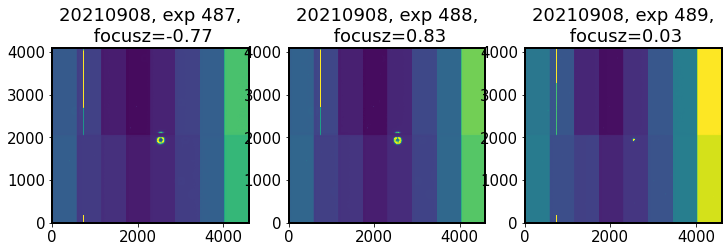

In [3]:
# analyze that for the test data 
at.previewExposures(yearMonthDay='20210908', expStart=487, expEnd=490)

## Run the ISR <a id='isr'></a>
[Go to table of contents](#toc)


First try with flats:


    ssh lsst-devl02

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib
    
    pipetask run  --data-query "exposure IN (2021090800487..2021090800489) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISRex --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types

The config file `testLatiss4.yaml` contains 

    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.Latiss
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: false
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'

While running the pipetask (with `lsst_distrib` version `w_2022_05`) I get the following warning :

    ...
    numexpr.utils INFO: Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
    numexpr.utils INFO: NumExpr defaulting to 8 threads.
    lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 7 quanta for 1 tasks, graph ID: '1643835917.696073-3368255'
    conda.common.io INFO: overtaking stderr and stdout
    conda.common.io INFO: stderr and stdout yielding back
    py.warnings WARNING: /software/lsstsw/stack_20220125/stack/miniconda3-py38_4.9.2-1.0.0/Linux64/obs_base/g20ff5da1ef+c94f9176fe/python/lsst/obs/base/formatters/fitsExposure.py:651: UserWarning: Reading file:///repo/main/u/czw/DM-32209/flatGen.20211013a-felh/20211013T214128Z/flat/r/FELH0600~empty/flat_LATISS_r_FELH0600~empty_RXX_S00_u_czw_DM-32209_flatGen_20211013a-felh_20211013T214128Z.fits with data ID {instrument: 'LATISS', detector: 0, physical_filter: 'FELH0600~empty', ...}: filter label mismatch (file is None, data ID is FilterLabel(band="r", physical="FELH0600~empty")).  This is probably a bug in the code that produced it.
      warnings.warn(
      ...

But it executes successfully. Show the postISR:


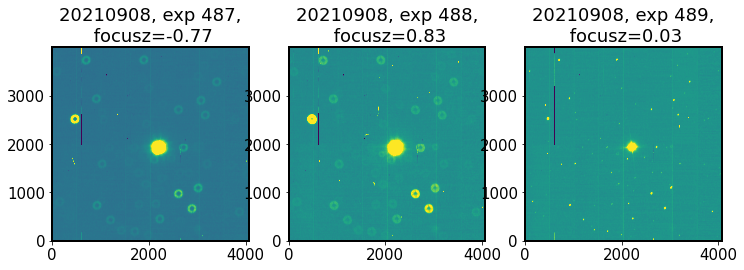

In [3]:
at.previewExposures(yearMonthDay='20210908', expStart=487, expEnd=490,
                    datasetRefOrType='postISRCCD',
                    collection='u/scichris/Latiss/postISRex')


## 1) Get sources for AOS pipeline from the in-focus exposure <a id='sources'></a>
[Go to table of contents](#toc)

Now the expected problem for some auxTel images was that the WCS attached to the exposure is 180 degree + several pixels off. Illustrate that by plotting the GAIA source catalog given the original WCS as well as rotated WCS:

In [4]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800489
                                        },
                      collections=['u/scichris/Latiss/postISRex'])


I load the sources from the reference catalog using the `ts_wep`  `GenerateDonutCatalogWcsTask` : 

In [18]:
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface
from lsst.daf import butler as dafButler
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (GenerateDonutCatalogWcsTask, 
                                                             GenerateDonutCatalogWcsTaskConfig)


# need to provide ra,dec, rotation angle of the exposure 
visitInfo = postIsr.getInfo().getVisitInfo()

boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

# Load the ts_wep RefCatalogInterface
refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)

htmIds = refCatInterface.getHtmIds()


butler = dafButler.Butler('/repo/main/', instrument='LATISS')
catalogName = 'gaia_dr2_20200414'
collections = 'refcats'

dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)


donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
donutCatConfig.filterName= 'phot_g_mean'
donutCatConfig.donutSelector.fluxField = 'phot_g_mean_flux'



In [19]:
# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }


Illustrate the original WCS and the 180-deg off WCS to check whether the 180 degree offset has been resolved (the ticket is marked as  'Done' https://jira.lsstcorp.org/browse/DM-31997)

In [ ]:
config.donutSelector.fluxField = 'g_flux'

In [20]:
#Get the sources from reference catalog assuming the original WCS
originalWcs = postIsr.getWcs()
originalDonutCatStruct = donutCatTask.run(dataRefs, postIsr, )


In [21]:
originalDonutCatStruct

Struct(donutCatalog=     coord_ra  coord_dec   centroid_x   centroid_y   source_flux
0    5.359813  -1.526682  2109.092970  2019.937176  2.216511e+09
1    5.345528  -1.526124   336.389946  2433.241557  1.886252e+07
2    5.361596  -1.527345  2923.169672   834.970819  7.442741e+06
3    5.360085  -1.527165  2617.003552  1112.312070  7.411704e+06
4    5.364554  -1.527185  3008.818035  1269.509361  4.271779e+06
..        ...        ...          ...          ...           ...
101  5.357088  -1.526352  1546.186308  2527.561073  1.349810e+04
102  5.363513  -1.527532  3269.646490   559.675143  1.340735e+04
103  5.344840  -1.526368   530.289210  1940.624684  1.302528e+04
104  5.337672  -1.527117   714.058353   198.798024  1.301660e+04
105  5.360981  -1.526471  1995.609029  2474.000699  1.264343e+04

[106 rows x 5 columns])

In [22]:
# Obtain the sources from the reference catalog with the WCS rotated by 180 degrees 
import lsst.geom
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix

rotationInDeg = 180 

info = postIsr.getInfo().getVisitInfo()
orientation = (info.getBoresightRotAngle().asDegrees()+rotationInDeg)* lsst.geom.degrees
#  info.getBoresightRotAngle()# 0 * lsst.geom.degrees  # 
flipX = originalWcs.isFlipped
scale =  originalWcs.getPixelScale() # 0.2 * lsst.geom.arcseconds  # how many arcsec per pixel 
cdMatrix = makeCdMatrix(scale=scale, orientation=orientation, flipX=flipX)

pxOrigin = originalWcs.getPixelOrigin()

crpix = pxOrigin
crval = originalWcs.getSkyOrigin() # lsst.geom.SpherePoint(0.0*lsst.geom.degrees, 0.0*lsst.geom.degrees)
rotatedWcs = makeSkyWcs(crpix=crpix, crval=crval, cdMatrix=cdMatrix)


Compare the original and rotated WCS:

In [23]:
originalWcs


FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [24]:
rotatedWcs


FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [25]:
# obtain source catalog using the rotated WCs postIsr.setWcs(rotatedWcs)
postIsr.setWcs(rotatedWcs)
rotatedDonutCatStruct =  donutCatTask.run(dataRefs, postIsr, )


In [26]:
#Make magnitude cuts for cleaner illustration

import astropy.units as u
import numpy as np 

originalCatalog  = originalDonutCatStruct.donutCatalog
rotatedCatalog = rotatedDonutCatStruct.donutCatalog

mag_list = (originalCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

originalCatalog['mags'] = mag_array
mask = mag_array<16
originalCatalogMagCut = originalCatalog[mask]


mag_list = (rotatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

rotatedCatalog['mags'] = mag_array
mask = mag_array<16
rotatedCatalogMagCut = rotatedCatalog[mask]


Plot the postISR image with GAIA sources given the original WCS (yellow) and WCS rotated by 180 degrees (red):

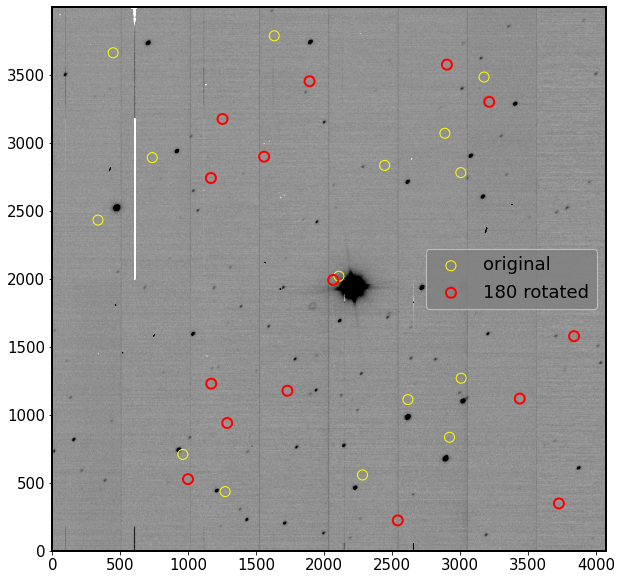

In [27]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
for cat,color,lw,label in zip([originalCatalogMagCut, rotatedCatalogMagCut], 
                    ['yellow', 'red'],
                       [1,2],
                       ['original', '180 rotated']):

    ax.scatter(cat['centroid_x'], 
           cat['centroid_y'], 
           s=100, 
           facecolors='none', edgecolors=color, lw=lw, 
           label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

Ok, so we see that the original one is several tens of pixels + some rotation off,  but it's not 180 degrees off. So at least for this dataset, this is not an issue any more. 

### 1a) Correct WCS using original WCS-based catalog as input for  astrometry fit <a id='originalWcs'></a>
[Go to table of contents](#toc)

Either way,  the original WCS is still ~20px off. 

Try using it as a first guess for the astrometry task":

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay

astromConfig = AstrometryTask.ConfigClass()
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.999
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15


Need to redefine filter label

In [29]:
# I'm forcing the exposure
# to have the same name as the one in the Gaia catalog for now

from lsst.afw.image import FilterLabel
postIsr.setFilterLabel(FilterLabel('phot_g_mean'))

Need to turn the `struct` to `sourceCatalog` - feeding `originalDonutCatStruct` to `solver.run` would not work, because it's not of `sourceCatalog` type. We turn `struct` into `sourceCatalog` by iterating over all rows, populating a new `afwTable.SourceCatalog` with sources... Based on https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_notebooks/Create_wcs_from_phosim_out_of_focus_no_transpose.ipynb

In [30]:
sourceSchema = afwTable.SourceTable.makeMinimalSchema()
measBase.SingleFrameMeasurementTask(schema=sourceSchema)  # expand the schema
sourceCat = afwTable.SourceCatalog(sourceSchema)

sourceCentroidKey = afwTable.Point2DKey(sourceSchema["slot_Centroid"])
sourceIdKey = sourceSchema["id"].asKey()
sourceRAKey = sourceSchema["coord_ra"].asKey()
sourceDecKey = sourceSchema["coord_dec"].asKey()
sourceInstFluxKey = sourceSchema["slot_ApFlux_instFlux"].asKey()
sourceInstFluxErrKey = sourceSchema["slot_ApFlux_instFluxErr"].asKey()


catalog = originalCatalogMagCut

Nrows = len(catalog)
sourceCat.reserve(Nrows)

for i in range(Nrows):
    src = sourceCat.addNew()
    src.set(sourceIdKey, i)
    
    # set ra,dec 
    ra = lsst.geom.Angle(catalog['coord_ra'].iloc[i], lsst.geom.radians)
    src.set(sourceRAKey, ra)

    dec = lsst.geom.Angle(catalog['coord_dec'].iloc[i], lsst.geom.radians)
    src.set(sourceDecKey, dec)

    # set the x,y centroid
    x = catalog['centroid_x'].iloc[i]
    y = catalog['centroid_y'].iloc[i]
    point = lsst.geom.Point2D(x,y)
    src.set(sourceCentroidKey, point)

    # set the flux and assume some small 1% flux error
    flux =  catalog['source_flux'].iloc[i]
    src.set(sourceInstFluxKey, flux)
    
    fluxErr = flux / 100.
    src.set(sourceInstFluxErrKey, fluxErr)

Display the WCS before and after to illustrate that running the `AstrometryTask` solver does update the WCS attached to the exposure

In [31]:
postIsr.getWcs()

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [32]:
solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=sourceSchema,)
results = solver.run(sourceCat=sourceCat, exposure=postIsr,)

TaskError: Fatal astrometry failure detected: mean on-sky distance = 7.155 arcsec > 0.500 (maxMeanDistanceArcsec)

So we see that this didn't work - the initial source location is too far for astrometry to converge:

    TaskError: Fatal astrometry failure detected: mean on-sky distance = 7.155 arcsec > 0.500 (maxMeanDistanceArcsec)

Earlier when I tried doing "rotate+shift WCS until the reference source catalog matches the observed sources" on the same exposure I needed rotation of ~6 degrees and several tens of px offset. For astrometry the max rotation is < 6 deg. 

### 1b) [works] Correct WCS using source detection catalog as input for  astrometry fit  <a id='detection'></a>
[Go to table of contents](#toc)

Here I convolve the image with Gaussian PSF to detect sources, and use that as an input for astrometry task. This approach could be turned to `ts_wep` task if needed, but it would require three exposures (one in-focus to detect sources, and two defocal, at the ~exact same position).

In [43]:
# Read the exposure again
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800489
                                        },
                      collections=['u/scichris/Latiss/postISRex'])

In [44]:
def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

Illustrate the kernel:

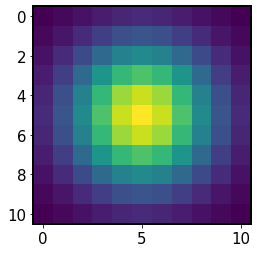

In [45]:
psf_array = gkern(l=11, sig=2.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)
plt.imshow(psf_image.array)

postIsr.setPsf(psf)

Run the `SourceDetectionTask`:

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay


#Use DM tasks to run: detection, measure using the simple PSF (no deblending)

schema = lsst.afw.table.SourceTable.makeMinimalSchema()

configDetection = SourceDetectionTask.ConfigClass()
configDetection.thresholdValue = 30 #30  # detection threshold in units of thresholdType
configDetection.thresholdType = "stdev"#"stdev"   # units for thresholdValue
configDetection.includeThresholdMultiplier = 1.0 
#configDetection.minPixels = 200 # 1000#
configDetection.minPixels = 500
#configDetection.charImage.background.weighting = False  
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)


measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table

#create copy of image to explicitly set the PSF
from copy import deepcopy
exposure = deepcopy(postIsr)
exposure.setPsf(psf)

# Run the detect the measure tasks
detect_result = detect.run(table, exposure,)# weighing=False)

catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
measure.run(catalog, exposure)

/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


Plot the resulting source catalog:

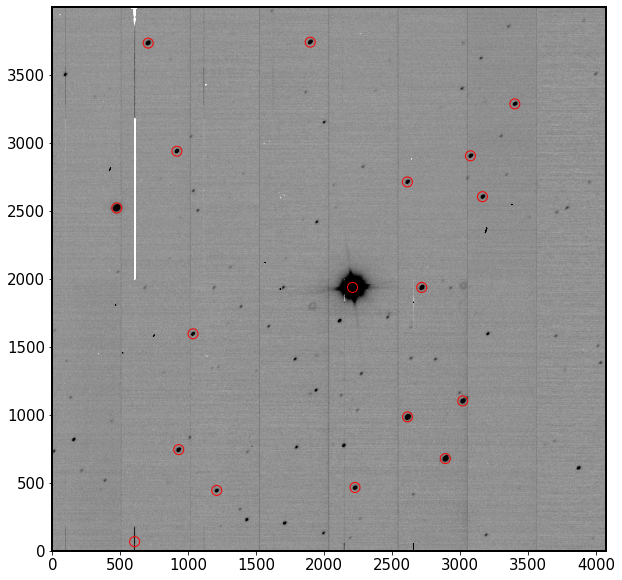

In [47]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()
data = postIsr.getImage().getArray()
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(catalog['slot_Centroid_x'], catalog['slot_Centroid_y'],s=100,facecolors='none', edgecolors='red',)

We see that this nicely detected sources (setting threshold to $30 \sigma$ ignored fainter stars which is fine, since we don't need all of them for astrometry).

Use that source catalog as an input for `AstrometryTask` fit:

In [48]:
# As above, I'm forcing the exposure
# to have the same name as the one in the Gaia catalog for now

from lsst.afw.image import FilterLabel
postIsr.setFilterLabel(FilterLabel('phot_g_mean'))

In [49]:
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface
from lsst.daf import butler as dafButler
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (GenerateDonutCatalogWcsTask, 
                                                             GenerateDonutCatalogWcsTaskConfig)


# need to provide ra,dec, rotation angle of the exposure 
visitInfo = postIsr.getInfo().getVisitInfo()

boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

# Load the ts_wep RefCatalogInterface
refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)

htmIds = refCatInterface.getHtmIds()


butler = dafButler.Butler('/repo/main/', instrument='LATISS')
catalogName = 'gaia_dr2_20200414'
collections = 'refcats'

dataRefs, dataIds = refCatInterface.getDataRefs(htmIds, butler, catalogName, collections)


donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
donutCatConfig.filterName= 'phot_g_mean'
donutCatConfig.donutSelector.fluxField = 'phot_g_mean_flux'

# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }


In [ ]:
# store the unchanged WCS in a variable to compare to the changes done 
# by running astrometry fit 
originalWcs = postIsr.getWcs()

In [50]:
astromConfig = AstrometryTask.ConfigClass()
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.999
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15

schema = lsst.afw.table.SourceTable.makeMinimalSchema()
solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
results = solver.run(sourceCat=catalog, exposure=postIsr,)

Running the astrometry task updates the WCS attached to the postIsr exposure. Compare the original and updated WCS:

In [51]:
originalWcs

FITS standard SkyWcs:
Sky Origin: (307.0794913975, -87.4725165002)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

In [52]:
postIsr.getWcs()

FITS standard SkyWcs:
Sky Origin: (306.9575674280, -87.4684455328)
Pixel Origin: (1930.01, 1989.89)
Pixel Scale: 0.0957529 arcsec/pixel

We see that they are different! Pull sources based on that WCS from the reference catalog, to make sure that it is the correct WCS:

In [53]:
updatedDonutCat =  donutCatTask.run(dataRefs, postIsr, )

updatedCatalog  = updatedDonutCat.donutCatalog

mag_list = (updatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

updatedCatalog['mags'] = mag_array
mask = mag_array<16
updatedCatalogMagCut = updatedCatalog[mask]


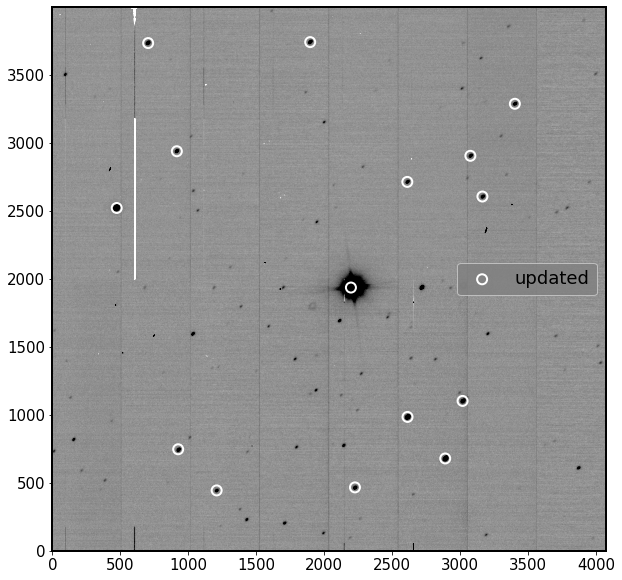

In [54]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
cat = updatedCatalogMagCut
color = 'white'
lw=2
label='updated'

ax.scatter(cat['centroid_x'], 
       cat['centroid_y'], 
       s=100, 
       facecolors='none', 
        edgecolors=color, lw=lw, 
       label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

This was just to confirm that the WCS that the astrometry arrived at is indeed correct! So these sources can be used as an input donut location to run the AOS pipeline.

## 2 Run Zernike estimation  <a id='zernikes'></a>
[Go to table of contents](#toc)

Next step is to update the WCS in the intra and extra focal exposures using this new in-focus WCS, and run the Zernike estimation:

In [55]:
collection = 'u/scichris/Latiss/postISRex'
expId = 2021090800487
exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':expId},
                      collections=[collection])


exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800488},
                      collections=[collection])

camera = butler.get("camera",dataId={"instrument": "LATISS"}, 
                    collections=[collection],)

In [56]:
focalWcs = postIsr.getWcs()

exposure_intra.setWcs(focalWcs)
exposure_extra.setWcs(focalWcs)

In [57]:
exp_pair = [exposure_intra, exposure_extra]

In [58]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, 
EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200, 
                                                         donutTemplateSize=200,
                                                         opticalModel='onAxis')
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)

# This will take around a minute to run 
zernikeOutput = estimateZernikeTask.run(exp_pair, [updatedCatalogMagCut], camera)



In [65]:
# store zernikes as a dict and illustrate the result 
zernikes = zernikeOutput.getDict()
fname = f'zerDic_{expId}_extra.npy'
np.save(fname,zernikes)
print(f'Stored the results as {fname} ')

Stored the results as zerDic_2021090800487_extra.npy 


In [66]:
zkResultsFile = f'zerDic_{expId}_extra.npy'
zkFit = np.load(zkResultsFile, allow_pickle=True).item()

Since here I pickled the results (rather than running the pipetask which would store it in the repo), I use a function that reads the fitted Zernikes from the pickle file: 

In [107]:
# plot the truth vs simulation... 
from lsst.daf import butler as dafButler
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from copy import copy
import yaml
from astropy.io import fits  
from astropy.visualization import ZScaleInterval

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18




Using results from zerDic_2021090800487_extra.npy


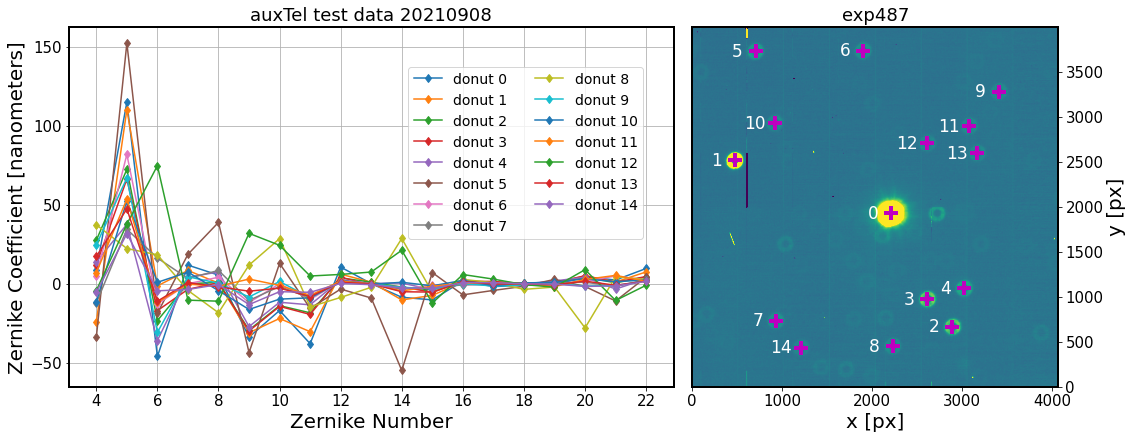

In [111]:
import imp
imp.reload(at)
at.plotZernikeImageFromPickle(expIntra=487, yearMonthDay='20210908', 
                   zkResultsFile=zkResultsFile, 
                   collection='u/scichris/Latiss/postISRex')

# Use donut template fitting on defocal images to get the source catalog (doesn't use WCS information) <a id='template'></a>
[Go to table of contents](#toc)

## Load the raw defocal images, do the ISR <a id='loadDefocal'></a>
[Go to table of contents](#toc)


Same as above -  [preview the raws](#raws) and [run the ISR](#isr)
 



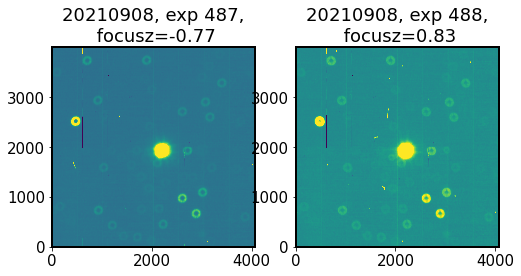

In [112]:
at.previewExposures(yearMonthDay='20210908', expStart=487, expEnd=489,
                    datasetRefOrType='postISRCCD',
                    collection='u/scichris/Latiss/postISRex')

## Run Zernike estimation using sources from donut template fitting <a id='fitDonuts'></a>
[Go to table of contents](#toc)

In [114]:
%matplotlib inline
from lsst.daf import butler as dafButler
import numpy as np
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from lsst.ts.wep.DonutDetector import DonutDetector
from copy import copy
import yaml
from astropy.io import fits  
from astropy.visualization import ZScaleInterval

def fit_zernikes(donutDetectTask,estimateZernikeTask,
                 expIntra, expExtra, 
                 year, monthDay,
                 collection, 
                 use_extra=False):
    # load the intra and extra-focal exposures 
    exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{expIntra}')
                                                }, collections=[collection])

    exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{expExtra}')
                                                }, collections=[collection])
    camera = butler.get("camera",dataId={"instrument": "LATISS"}, 
                        collections=[collection],)
    
    # find donuts from one of the exposures
    if use_extra:
        exposure = copy(exposure_extra)
    else:
        exposure = copy(exposure_intra)
        
    donutCatalog = donutDetectTask.run(exposure)
    donutCat = donutCatalog.donutCatalog

    # declare the exposure pair
    exposure_pair = [exposure_intra, exposure_extra ]
    zernikeOutput = estimateZernikeTask.run(exposure_pair, [donutCat], camera)

    # store zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{year}{monthDay}00{expIntra}_{expExtra}_n.npy'
    np.save(fname,zernikes, )
    print(f'Stored the results as {fname} ')



Initialize estimate Zernike task, and run Zk fitting:

In [115]:
from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig
)
from lsst.ts.wep.task.EstimateZernikesLatissTask import (
    EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
)

donutDetectConfig = GenerateDonutDirectDetectTaskConfig(donutTemplateSize = 200,
                                            instName = 'auxTel',
                                            opticalModel = 'onAxis',
                                            peakThreshold = 0.99,
                                            binaryChoice = 'deblend') # adaptative image thresholding
donutDetectTask = GenerateDonutDirectDetectTask(config=donutDetectConfig)


estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200, 
                                                         donutTemplateSize=200,
                                                         opticalModel='onAxis')
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)

# initialize the butler
butler = dafButler.Butler('/repo/main/')

fit_zernikes(donutDetectTask, estimateZernikeTask, expIntra=487, expExtra=488, year='2021', monthDay='0908',
             collection='u/scichris/Latiss/postISRex',)


Stored the results as zerDic_2021090800487_488_n.npy 


Plot the results:

Using results from zerDic_2021090800487_488_n.npy


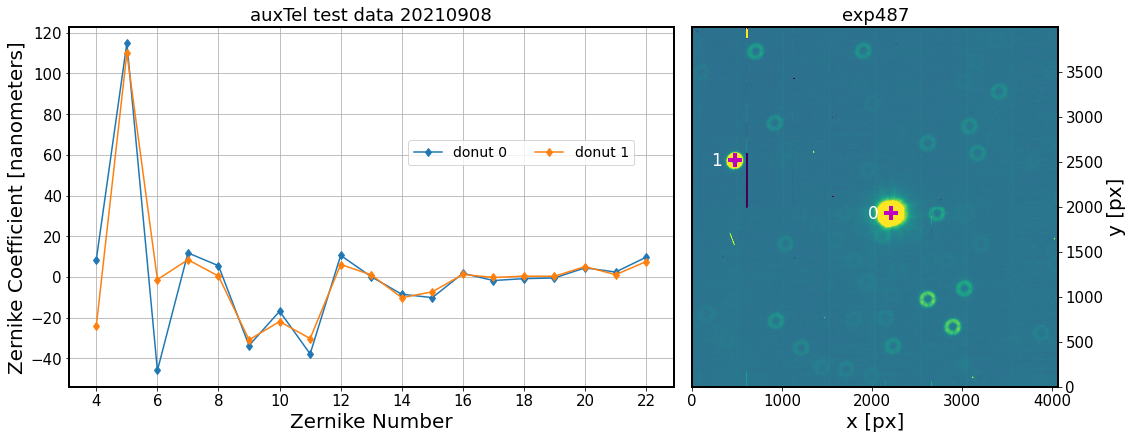

In [116]:
expIntra=487; expExtra=488; yearMonthDay='20210908'
at.plotZernikeImageFromPickle(expIntra=487, yearMonthDay='20210908', 
                   zkResultsFile=f'zerDic_{yearMonthDay}00{expIntra}_{expExtra}_n.npy', 
                   collection='u/scichris/Latiss/postISRex')




# Summary and conclusion <a id='summary'></a>
[Go to table of contents](#toc)

There are drawbacks to both methods we use to select sources.  

First, the [method detecting sources](#detection) in the in-focus image using `sourceDetectionTask` relies on provided PSF (since PSF characterization is lacking), and on set detection thresholds (in particular, `configDetection.thresholdValue` and `configDetection.minPixels` ). Setting these to be too low may result in eg. an error in that all pixels are masked and background cannot be estimated. 



Second, the [method of template fitting](#fitDonuts) to detect defocal donuts using  `DonutDetector` `detectDonuts` depends on the settings passed therein, consisting of `blendRadius` in pixels, and `peakThreshold`. We also made a choice to remove the `blended` donuts to clean up the catalog. This method works well when required  to detect a few brightest donuts in the image. However, if it is  important to use as many donuts as possible, then it may be easier to select them using a magnitude cut  on the reference star catalog used in the first method.

# Everything as a pipetask <a id='pipetask'></a>
[Go to table of contents](#toc)

The WCS example above could not be run using the pipeline because the initial WCS guess in `GenerateDonutCatalogWcsTask.py` uses WCS attached to the exposure (https://github.com/lsst-ts/ts_wep/blob/abd15793e7e0f0484de03661caf4c1783e78a24f/python/lsst/ts/wep/task/GenerateDonutCatalogWcsTask.py#L240), which for auxTel may not be as close as needed for astrometry to converge (rotation < 6 degrees).

Regardless of the accuracy of the WCS attached to the auxTel exposure, the `GenerateDonutDirectDetectTask` can be used to detect donuts via template fitting. 

Once the donut catalog is provided via either of these tasks, the `EstimateZernikesLatissTask` can use that to calculate Zernikes and store everything as a pipetask structure. 

To run everything as pipetask one uses a `yaml` file that contains configuration for all employed tasks. For instance,
to analyze the example data from this notebook we could use a file very similar to the test https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testLatissPipeline.yaml :

    description: auxTel ISR--> donut selection--> Zernike estimation pipeline
    instrument: lsst.obs.lsst.Latiss
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: false
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'
      generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.GenerateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          donutTemplateSize: 200
          removeBlends: True
          instName: 'auxTel'
          opticalModel: 'onAxis'
      estimateZernikesLatissTask:
        class: lsst.ts.wep.task.EstimateZernikesLatissTask.EstimateZernikesLatissTask
        config:
          # And here we specify the configuration settings
          donutTemplateSize: 200
          donutStampSize: 200
          initialCutoutPadding: 40
          instName: 'auxTel'
          opticalModel: 'onAxis'
          
          
Then the entire pipetask can be run with 

    pipetask run  --data-query "exposure IN (2021090800487,2021090800488) AND instrument='LATISS' AND visit_system=0" -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib  --output u/scichris/Latiss/postISRex1 --pipeline /project/scichris/aos/ts_wep/tests/testData/pipelineConfigs/testLatissPipeline.yaml  --register-dataset-types
    
And the results can be accessed with:



In [7]:
repoDir = '/repo/main/'
butler = dafButler.Butler(repoDir)
registry = butler.registry

# query the registry to find out the 
# exposure just in case we forgot the exact exposure number,
# but we knew the collection name (run)
instrument = 'LATISS'
detector = 0
collection = 'u/scichris/Latiss/postISRex1'
dataId0 = dict(instrument=instrument)

# take the first exposure from the list of
# two available ones
dataset = next(iter(butler.registry.queryDatasets(
                    datasetType='postISRCCD',
                    dataId=dataId0, 
                    collections=[collection]  )))
expN = dataset.dataId["exposure"]

# construct a dataId  for postISR image
dataId = {'detector':detector, 
          'instrument':instrument,
          'exposure':expN}
print('Using ', dataId, ' for postISRCCD')

# read the postISR exposure 
postIsrExp = butler.get('postISRCCD', dataId,
           collections=[collection])

# construct a dataId for zernikes and donut catalog:
# switch exposure to visit 
dataId = {'detector':detector, 'instrument':instrument,
          'visit':expN}
print('Using ', dataId, ' for Zernikes and donut catalog')

# the raw Zernikes 
zkRaw =  butler.get('zernikeEstimateRaw', dataId=dataId,
                    collections=[collection])

# the donut source catalog 
srcCat = butler.get('donutCatalog', dataId=dataId, 
                    collections=[collection])


Using  {'detector': 0, 'instrument': 'LATISS', 'exposure': 2021090800487}  for postISRCCD
Using  {'detector': 0, 'instrument': 'LATISS', 'visit': 2021090800487}  for Zernikes and donut catalog


I use a function that employs these data products to plot the combined illustration:

{'detector': 0, 'instrument': 'LATISS', 'exposure': 2021090800487}
{'detector': 0, 'instrument': 'LATISS', 'visit': 2021090800487}


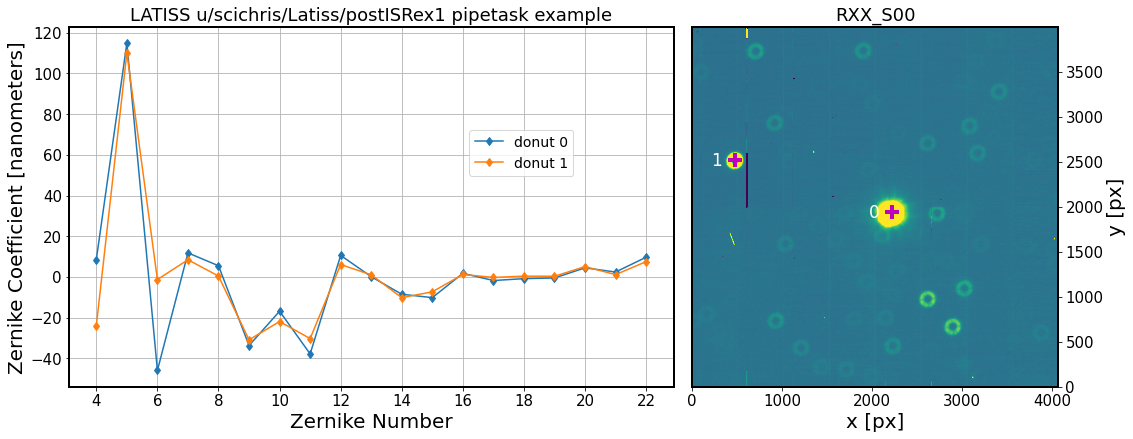

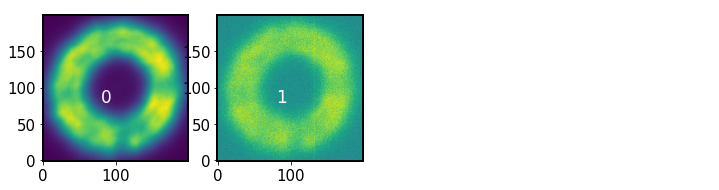

In [11]:
%matplotlib inline
import sys
sys.path.append('/project/scichris/aos/')
import analysisTools as at
import imp
imp.reload(at)
at.plotZernikeImage(repoDir='/repo/main/',
                   collection='u/scichris/Latiss/postISRex1',
                   instrument='LATISS',
                   detector=0,
                   titleAdd= 'pipetask example')
